#### Importing libraries

In [62]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import statsmodels.api as sm

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

#### Reading data

In [2]:
df = pd.read_csv('loandata.csv')

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.shape

(614, 13)

In [5]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

# Handling Missing values

#### Type of Missing Values

<b>1] Missing Completely at Random (MCAR)</b> - In this case, missing values are randomly distributed across the variable, and it is assumed that      other variables can’t predict the missing value.

<b>2] Missing at Random (MAR)</b> - In MAR, missing data is randomly distributed, but it can be predicted by other variables/data points. For          example, sensors could not log data for a minute due to a technical glitch, but it can be interpolated by previous and subsequent            readings.

<b>3] Missing Not at Random (MNAR)</b> - In this case, missing values are not random and missing systematically. For example, people avoid certain     information while filling out surveys.

In [6]:
df.groupby('Loan_Status')['Gender'].value_counts().reset_index()

,Loan_Status,Gender,count
0,N,Male,150
1,N,Female,37
2,Y,Male,339
3,Y,Female,75


#### As we can see here, Males count is greater than female. We will use mode as out imputer for NaN values in Gender column

In [7]:
df['Gender'].value_counts()

Gender
Male      489
Female    112
Name: count, dtype: int64

In [8]:
df.groupby('Loan_Status')['Married'].value_counts().reset_index()

,Loan_Status,Married,count
0,N,Yes,113
1,N,No,79
2,Y,Yes,285
3,Y,No,134


In [9]:
impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mode.fit(df[['Gender','Married']])
df[['Gender','Married']] = impute_mode.transform(df[['Gender','Married']])

In [10]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


* As we can see in the dataset, self_employed and credit_history are the columns which could be predicted by looking at the nearest neighbors

In [11]:
df['Self_Employed'] = df['Self_Employed'].map({'Yes' : 1, 'No' : 0}) 
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 3)
df[['Credit_History', 'Self_Employed']] = imputer.fit_transform(df[['Credit_History', 'Self_Employed']])

In [12]:
df.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
print(df.Loan_Amount_Term.mean())

342.0


In [14]:
df.groupby('Loan_Status')['Loan_Amount_Term'].value_counts()

Loan_Status  Loan_Amount_Term
N            360.0               153
             180.0                15
             480.0                 9
             300.0                 5
             36.0                  2
             84.0                  1
             240.0                 1
Y            360.0               359
             180.0                29
             300.0                 8
             480.0                 6
             84.0                  3
             120.0                 3
             240.0                 3
             60.0                  2
             12.0                  1
Name: count, dtype: int64

#### Here we can see that customers have mostly opted for 360 days, whether N or Y, so we can use Mode() here to simply fill the NaN 

In [15]:
df.groupby('Loan_Status')['LoanAmount'].value_counts()

Loan_Status  LoanAmount
N            110.0         5
             160.0         4
             113.0         4
             100.0         4
             80.0          4
                          ..
Y            86.0          1
             87.0          1
             89.0          1
             101.0         1
             700.0         1
Name: count, Length: 280, dtype: int64

In [16]:
imputer = KNNImputer(n_neighbors = 3)
df[['LoanAmount', 'Loan_Amount_Term']] = imputer.fit_transform(df[['LoanAmount', 'Loan_Amount_Term']])

# Checking feature

* Credit history tells us that having a good score does have impact on loan approval

/home/pratik/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


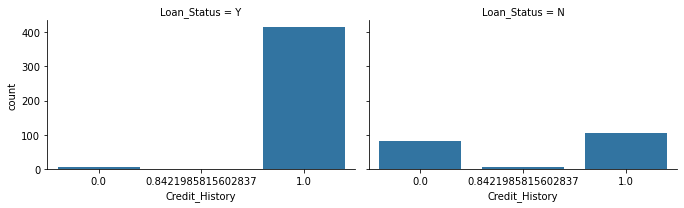

In [17]:
grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Credit_History');

* Having a property area no matter where (semi, urban or rural) also helps in getting loan but does not differentiate exactly

/home/pratik/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


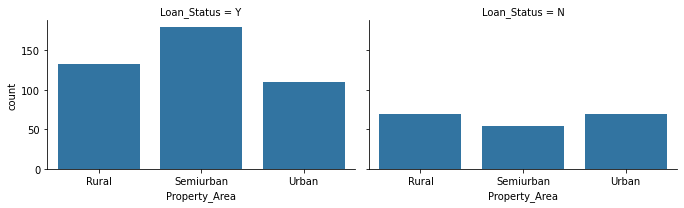

In [18]:
grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Property_Area');

* Not Self-Employed also mostly gets approval for loans

/home/pratik/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


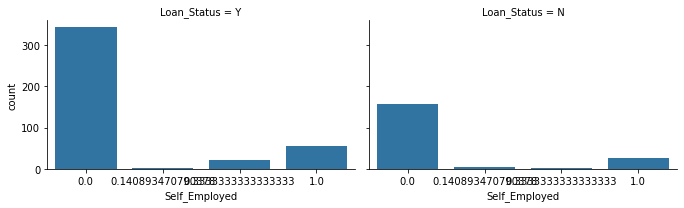

In [19]:
grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Self_Employed');

* Education loans for graduates gets approved more comparatavily

/home/pratik/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


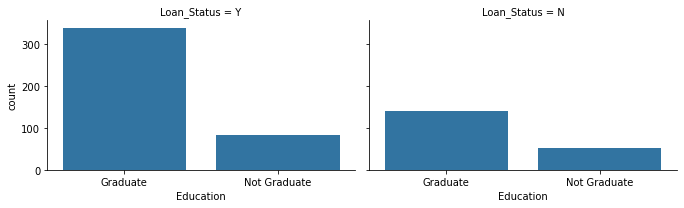

In [20]:
grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Education');

/home/pratik/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


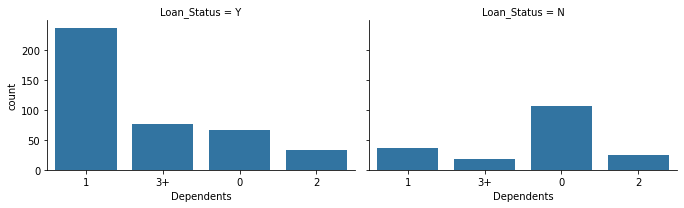

In [21]:
grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Dependents');

In [22]:
# As it do not have many categories, I tried using mapping to encode them
df['Dependents'] = df['Dependents'].map({'0':0, '1' : 1, '2':2, '3+' : 3})

In [23]:
# There are some NaN values, as there are not any outliers I used median
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].median())

#### These countplot shows the relation between the independent and dependent variable
#### As we saw, these features are important for the model to make predictions

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    float64
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    float64
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 62.5+ KB


* There are some Categorical features so, using LabelEncoder to encode them

In [25]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cat = ['Gender', 'Married', 'Education', 'Property_Area', 'Loan_Status']

def encode(data):
    for i in cat:
        data[i] = encoder.fit_transform(data[i])
    return data

In [26]:
encode(df)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0.0,0,0.0,5849,0.0,104.666667,360.0,1.0,2,1
1,LP001003,1,1,1.0,0,0.0,4583,1508.0,128.000000,360.0,1.0,0,0
2,LP001005,1,1,0.0,0,1.0,3000,0.0,66.000000,360.0,1.0,2,1
3,LP001006,1,1,0.0,1,0.0,2583,2358.0,120.000000,360.0,1.0,2,1
4,LP001008,1,0,0.0,0,0.0,6000,0.0,141.000000,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,0,0.0,0,0.0,2900,0.0,71.000000,360.0,1.0,0,1
610,LP002979,1,1,3.0,0,0.0,4106,0.0,40.000000,180.0,1.0,0,1
611,LP002983,1,1,1.0,0,0.0,8072,240.0,253.000000,360.0,1.0,2,1
612,LP002984,1,1,2.0,0,0.0,7583,0.0,187.000000,360.0,1.0,2,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    int64  
 2   Married            614 non-null    int64  
 3   Dependents         614 non-null    float64
 4   Education          614 non-null    int64  
 5   Self_Employed      614 non-null    float64
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    int64  
 12  Loan_Status        614 non-null    int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 62.5+ KB


In [28]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Splitting the data

In [29]:
X = df.iloc[:, 2:-1]
y = df.iloc[:, -1]

In [30]:
print(X.shape)
print(y.shape)

(614, 10)
(614,)


* Checking skewness to understand the distribution of selected features and accordingly applying suitable Scaler

In [31]:
# skewness along the index axis
X.skew(axis = 0, skipna = True)

Married             -0.644850
Dependents           1.015551
Education            1.367622
Self_Employed        2.025125
ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.737882
Loan_Amount_Term    -2.379475
Credit_History      -2.014526
Property_Area       -0.066196
dtype: float64

* Train and test - test data = 15% as we dont have enough data

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0)
    
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (521, 10)
y_train shape (521,)
X_test shape (93, 10)
y_test shape (93,)


* Looking at the disstribution, it isnot skewed much at either positive and negative side, so decided to use StandardScaler

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

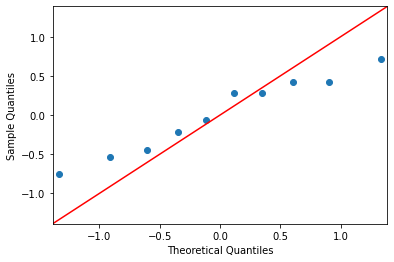

In [51]:
# create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(X_train[-1], line='45')

plt.show()

#### Normal Distribution -
    * Probability distribution that is symmetric about the mean, showing that data near the mean are more frequent in occurrence than data         far from the mean

In [37]:
model = LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced')

In [38]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')

In [39]:
y_pred = model.predict(X_test)

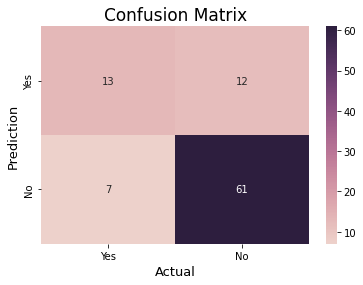

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels=['Yes','No'],
            yticklabels=['Yes','No'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score

def loss(y_true, y_pred):
    precison = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return f'precision : {round(precison*100, 2)}% recall : {round(recall*100, 2)}%  f1_score : {round(f1*100, 2)}%  accuracy : {round(accuracy*100, 2)}%'

In [42]:
loss(y_test, y_pred)

'precision : 83.56% recall : 89.71%  f1_score : 86.52%  accuracy : 79.57%'

#### ROC Curve
It tells how much the model is capable of distinguishing between classes.<br> 
Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.<br>
By analogy, the Higher the AUC, the better the model is at distinguishing between Approved loan and Not approved loan.

#### The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


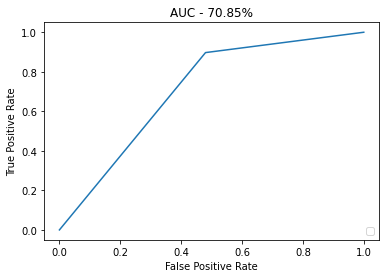

In [43]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.title('AUC - '+ str(round(auc*100, 2)) + '%')
plt.show()

In [44]:
# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC

In [45]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
              {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3]}]
grid_search = GridSearchCV(estimator = SVC(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)

In [46]:
grid_search.best_score_

0.8061355311355312

In [47]:
grid_search.best_params_

{'C': 0.01, 'kernel': 'linear'}

In [48]:
classifier = SVC(C=0.01, kernel='linear')
classifier.fit(X_train,y_train)
svc_y_pred = classifier.predict(X_test)

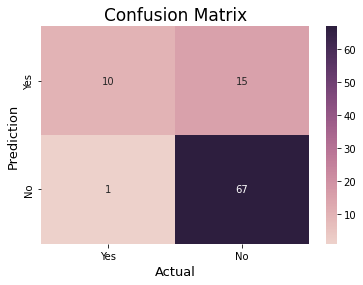

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,svc_y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels=['Yes','No'],
            yticklabels=['Yes','No'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [50]:
loss(y_test, svc_y_pred)

'precision : 81.71% recall : 98.53%  f1_score : 89.33%  accuracy : 82.8%'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


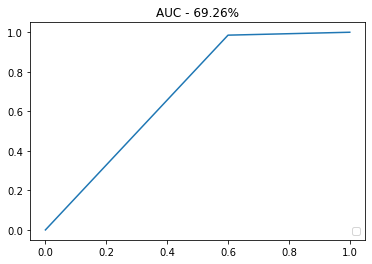

In [51]:
fpr, tpr, _ = metrics.roc_curve(y_test,  svc_y_pred)
auc = metrics.roc_auc_score(y_test, svc_y_pred)
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.title('AUC - '+ str(round(auc*100, 2)) + '%')
plt.show()

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              'ccp_alpha': [0.001, 0.01,1,10, 100],
              'max_depth' : [1, 2, 3, 4,5, 6],
              'criterion' :['gini', 'entropy']
             }
tree_clf = DecisionTreeClassifier(random_state=1)
grid_search = GridSearchCV(estimator=tree_clf, param_grid = param_grid, cv = 10, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'ccp_alpha': [0.001, 0.01, 1, 10, 100],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6]},
             verbose=True)

In [53]:
final_model = grid_search.best_estimator_
final_model

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=1, random_state=1)

In [54]:
#Training the model
tree_clas = DecisionTreeClassifier(ccp_alpha=0.001,
                       max_depth=1,
                       random_state=1)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

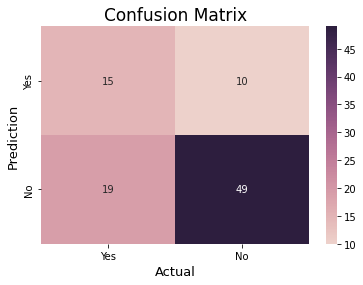

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels=['Yes','No'],
            yticklabels=['Yes','No'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [56]:
loss(y_test, y_pred)

'precision : 83.05% recall : 72.06%  f1_score : 77.17%  accuracy : 68.82%'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


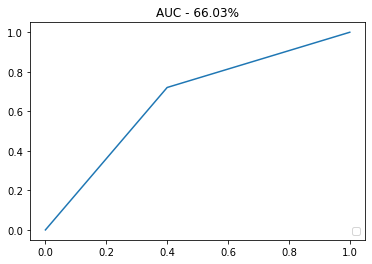

In [57]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr)
plt.legend(loc=4)
plt.title('AUC - '+ str(round(auc*100, 2)) + '%')
plt.show()

In [58]:
from prettytable import PrettyTable

In [59]:
myTable = PrettyTable(["Model Name", "Precison", "Recall", "AUC"])
  
# Add rows
myTable.add_row(["Logistic", 88, 83, "74.8 %"])
myTable.add_row(["SVC", 86, 97, "75.6 %"])
myTable.add_row(["DecisonTree", 82, 72, "72.7 %"])
  
print(myTable)

+-------------+----------+--------+--------+
|  Model Name | Precison | Recall |  AUC   |
+-------------+----------+--------+--------+
|   Logistic  |    88    |   83   | 74.8 % |
|     SVC     |    86    |   97   | 75.6 % |
| DecisonTree |    82    |   72   | 72.7 % |
+-------------+----------+--------+--------+


As I tried to increase features, decision tree's AUC decreases from 72% to 66%, but Logistic regression and SVC's performance increases.